# Задание 4.

https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg

Итоговое задание - выполнить сегментацию полипов согласно приложенного датасета.

1. Подготовить данные должным образом.
2. Попробовать различные архитектуры, выбрать наилучшую.
3. Попробовать аугментацию, трансферное обучение.
4. Визуализировать предсказания выбранной модели.
5. Составить обобщающий хороший вывод.
6. (по желанию) сделать API.


https://habr.com/ru/companies/otus/articles/442918/ - как делать API для ML

Сдавать как обычно Гитхаб или Гугл колаб.

# Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
from time import time

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

In [ ]:
from zipfile import ZipFile

In [ ]:
from skimage.io import imread
from skimage.transform import resize

In [ ]:
from IPython.display import clear_output

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
!pip install segmentation-models-pytorch -q

In [ ]:
import segmentation_models_pytorch as smp

# Подготовка данных

In [ ]:
with ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
images = []
masks = []
root_dir = 'Kvasir-Capsule'

In [ ]:
for current_root, dirs, files in os.walk(root_dir):
    if 'annotated_images' in current_root:
        continue
    for file in files:
        file_path = os.path.join(current_root, file)
        if current_root.endswith('images'):
            images.append(imread(file_path))
        elif current_root.endswith('masks'):
            masks.append(imread(file_path))

## Изменение размера изображения

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

Визуализация изображений и их масок

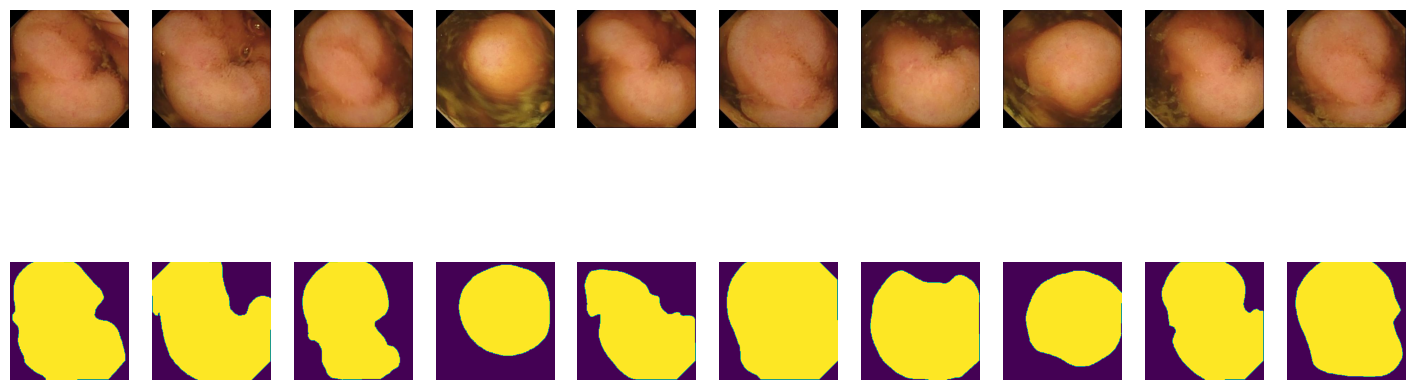

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 10, i+11)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

## Разделение данных для обучения

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [35, 45])

In [ ]:
# данные для обучения
len(tr)

35

In [ ]:
# данные для валидации
len(val)

10

In [ ]:
# данные для теста
len(ts)

10

## Загрузка данных

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=10, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=10, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=10, shuffle=True)

## device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Функции

## Метрики

Метрика IoU (Intersection over Union) используется для оценки точности алгоритмов сегментации изображений и объектов. Она измеряет степень перекрытия между предсказанными и истинными областями.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

## Функции потерь

Функция потерь DICE (или Dice Loss) часто используется в задачах сегментации изображений, чтобы оценить качество совпадения предсказанных и истинных масок. Она является производной от коэффициента Dice (Dice Coefficient), который похож на метрику IoU, но имеет различия в вычислениях.

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.flatten(torch.sigmoid(y_pred))
    y_real = torch.flatten(y_real)
    num = 2 * torch.sum(y_real * y_pred)
    den =  torch.sum(y_real + y_pred)
    res = 1 - (num / den)
    return res

Функция потерь бинарной кросс-энтропии (Binary Cross-Entropy, BCE) широко используется для задач бинарной классификации, включая бинарную сегментацию изображений. Она измеряет расхождение между предсказанными значениями и истинными метками.

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred.to(device)
    y_real = y_real.to(device)
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Обучение

In [ ]:
def seed_everything(seed=7575):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=7575)


def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    test_losses = []
    scores = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)

        train_losses.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)


        model.eval()
        with torch.no_grad():
            Y_pred = model(X_val.to(device)).detach().cpu()
            Y_hat = torch.sigmoid(Y_pred)
            test_losses.append(loss_fn(Y_val, Y_pred))
            scores.append(score_model(model, iou_pytorch, data_val))


        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_losses, test_losses, scores

## Предсказание

In [ ]:
def predict(model, data):
    model.eval()
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

## Расчет метрик

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = torch.sigmoid(model(X_batch)) > threshold
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Итоговая таблица результатов

In [ ]:
df_results = pd.DataFrame(columns=['model', 'loss_function', 'score'])

## Визуализация результатов

In [ ]:
def plot(losses_train, losses_val, scores):
  fig = plt.figure(figsize = (20, 5))
  fig.add_subplot(121)
  plt.plot([x.cpu().detach().numpy() for x in losses_train], label="train_loss",)
  plt.plot([x.cpu().detach().numpy() for x in losses_val], label="val_loss",)
  plt.grid()
  plt.legend()
  fig.add_subplot(122)
  plt.plot(scores, label="score", )
  plt.grid()
  plt.legend()
  plt.show()

  score_max = max(scores)

  print(f' функции потерь                                                         score на валидационной выборке : {score_max}')
  return score_max

## Нормализация и активация сверточного слоя

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      # nn.ReLU(inplace=True),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      # nn.ReLU(inplace=True)
      nn.ReLU(),)
  return conv

# Нейронная сеть для семантической сегментации изображений

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2,2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU())
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU())
        self.upsample2 = nn.MaxUnpool2d(2,2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(2,2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(1),
                                      nn.ReLU())

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, indices0 = self.pool0(e0)

        e1 = self.enc_conv1(e0)
        e1, indices1 = self.pool0(e1)

        e2 = self.enc_conv2(e1)
        e2, indices2 = self.pool0(e2)

        e3 = self.enc_conv3(e2)
        e3, indices3 = self.pool0(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder

        d0 = self.upsample0(b, indices3)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(d3)

        return d3

## Кросс-Энтропия

Бинарная перекрестная энтропия часто используется в логистической регрессии, нейронных сетях и других алгоритмах бинарной классификации, поскольку она хорошо подходит для оптимизации моделей, которые предсказывают вероятности классов. Она позволяет модели обучаться, минимизируя разницу между предсказанными вероятностями и истинными значениями.

In [ ]:
model_bce = SegNet().to(device)

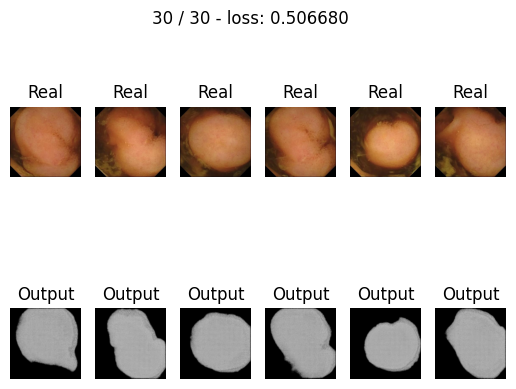

In [ ]:
max_epochs = 30
optim = torch.optim.Adam(model_bce.parameters(), lr=0.001)
losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val)


In [ ]:
score_model(model_bce, iou_pytorch, data_val)

0.39000001549720764

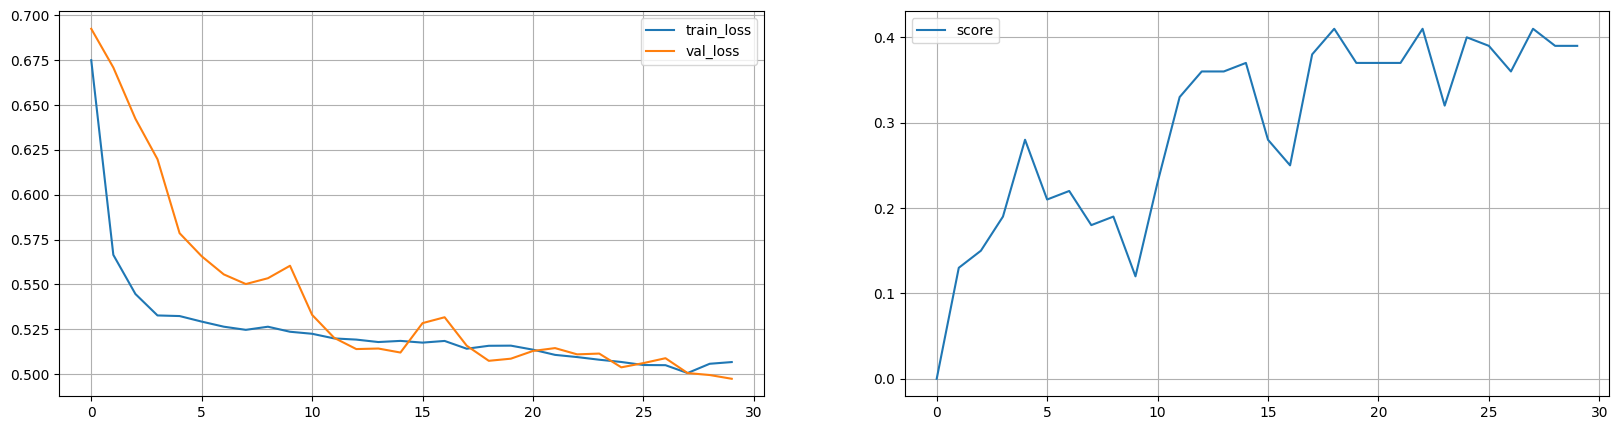

 функции потерь                                                         score на валидационной выборке : 0.4099999964237213


In [ ]:
max_score_val = plot(losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce)

In [ ]:
df_results = pd.concat([pd.DataFrame([['SegNet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results


,model,loss_function,score
0,SegNet,bce_loss,0.41


На 18-й эпохе кросс-энтропия дала максимальный результат.

## DICE

Cтатистическая мера, используемая для вычисления схожести между двумя наборами данных. Она широко применяется в задачах анализа данных, машинного обучения, компьютерного зрения и других областях, где необходимо измерить степень совпадения между двумя множествами, например, при сравнении сегментированных изображений.

In [ ]:
model_dice = SegNet().to(device)

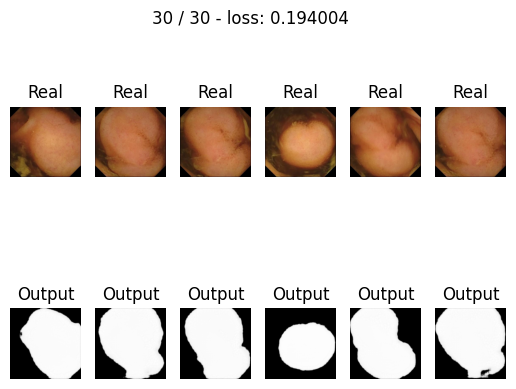

In [ ]:
max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=0.01)
losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.8500000238418579

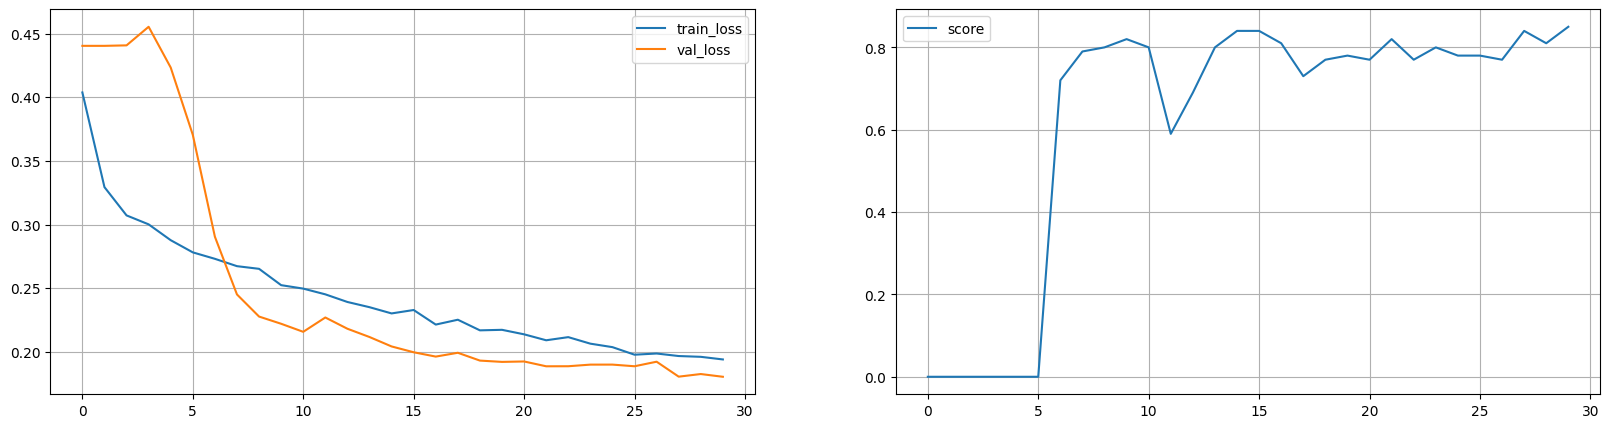

 функции потерь                                                         score на валидационной выборке : 0.8500000238418579


In [ ]:
max_score_val = plot(losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice)



После 13-й эпохи метрика стабилизируется.

In [ ]:
df_results = pd.concat([pd.DataFrame([['SegNet', 'dice_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,SegNet,dice_loss,0.85
1,SegNet,bce_loss,0.41


# U-Net

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = double_conv(32, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(256, 512)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = double_conv(512+256, 256)
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = double_conv(256+128, 128)
        self.upsample2 = nn.Upsample(128) # 64 -> 128
        self.dec_conv2 = double_conv(128+64, 64)
        self.upsample3 = nn.Upsample(256) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=64 + 32, out_channels=32, kernel_size=3, padding=1),
                              nn.BatchNorm2d(32),
                              # # nn.ReLU(inplace=True),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
                              )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

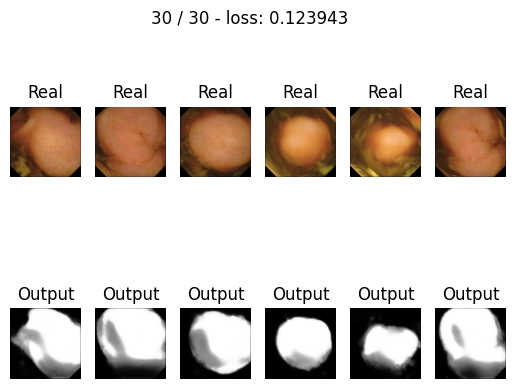

In [ ]:
max_epochs = 30
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001)
losses_train_unet_1_bce, losses_test_unet_1_bce, scores_unet_1_bce = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)


In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7700000405311584

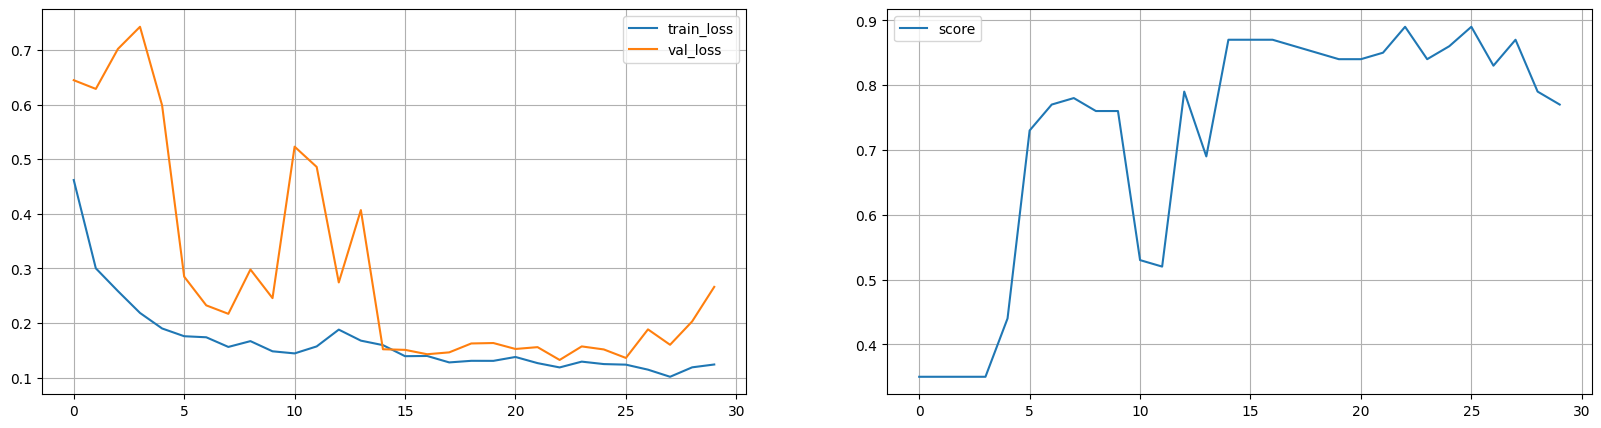

 функции потерь                                                         score на валидационной выборке : 0.89000004529953


In [ ]:
max_score_val = plot(losses_train_unet_1_bce, losses_test_unet_1_bce, scores_unet_1_bce)

In [ ]:
df_results = pd.concat([pd.DataFrame([['Unet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,Unet,bce_loss,0.89
1,SegNet,dice_loss,0.85
2,SegNet,bce_loss,0.41


Показатели U-Net выше, чем у сверточной сети.

# Аугментация

Аугментация изображений — это важный этап предобработки данных, который помогает увеличить объем обучающей выборки и улучшить обобщающую способность модели. Существует множество методов аугментации, таких как повороты, сдвиги, изменения яркости, контраста, отражения и другие.

In [ ]:
# Определяем трансформации
transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.6),
    A.RandomBrightnessContrast(p=0.8),
    A.Resize(256, 256),
    ToTensorV2()
])

In [ ]:
# Создание кастомного датасета
class CustomSegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [ ]:
dataset = CustomSegmentationDataset(X, Y, transform=transform)

In [ ]:
train_length = len(tr)
val_length = len(val)
test_length = len(ts)

In [ ]:
# Разделение датасета
lengths = [train_length, val_length, test_length]
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

In [ ]:
# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
model_transfer = smp.Unet(
    encoder_name="resnet34",        # Используем предобученный ResNet34
    encoder_weights="imagenet",     # Загрузим веса, предобученные на ImageNet
    in_channels=3,                  # Число каналов входного изображения (RGB)
    classes=1,                      # Число классов на выходе (1 для бинарной сегментации)
)

In [ ]:
model_transfer.to(device);

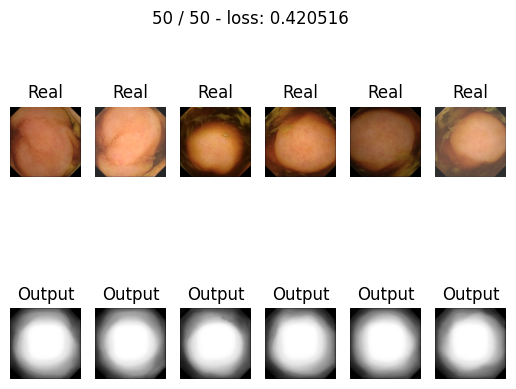

In [ ]:
max_epochs = 50
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.001)
losses_train_unet_2_transfer, losses_test_unet_2_transfer_bce, scores_unet_2_transfer_bce = train(model_transfer, optimizer, bce_loss, max_epochs, train_loader, val_loader)


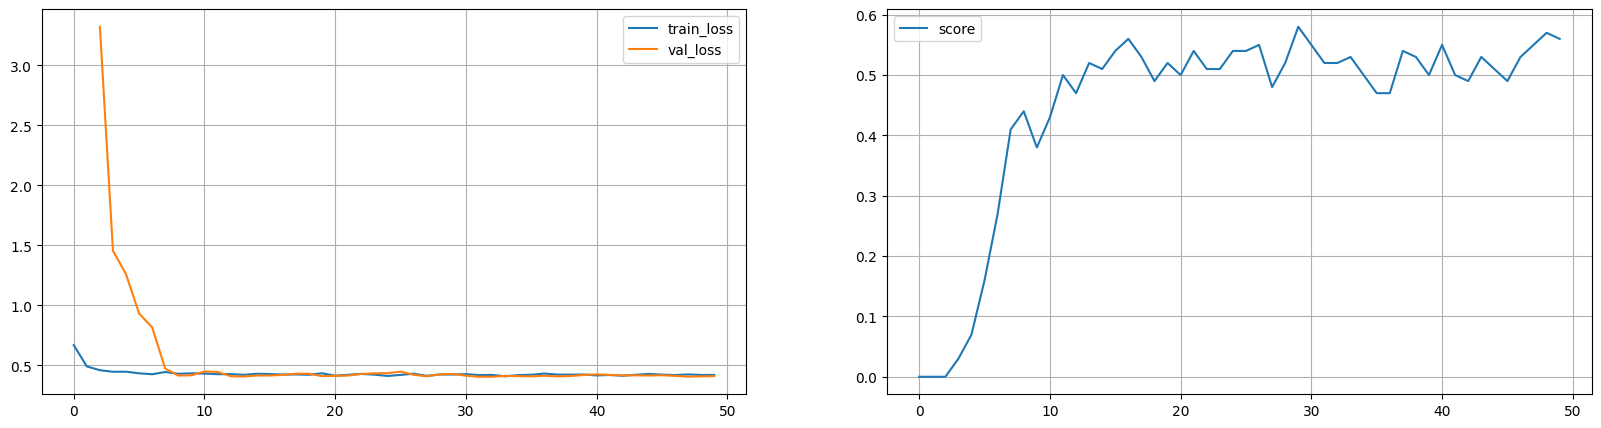

 функции потерь                                                         score на валидационной выборке : 0.5799999833106995


In [ ]:
max_score_val = plot(losses_train_unet_2_transfer, losses_test_unet_2_transfer_bce, scores_unet_2_transfer_bce)

In [ ]:
df_results = pd.concat([pd.DataFrame([['Unet_transf_aug', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,Unet_transf_aug,bce_loss,0.58
1,Unet,bce_loss,0.89
2,SegNet,dice_loss,0.85
3,SegNet,bce_loss,0.41


# Вывод:

Было сделано 4 расчета различных конфигураций моделей.

Сверточная сеть с функцией потерь bce,

сверточная сеть с функцией потерь dice,

U-Net,

U-Net с трансферным обучением и  аугментацией.

Лучший результат показала нейроная сеть U-Net без трансферного обучения и аугментации. На втором месте сверточная сеть с функцией потерь dice.

Вероятные причины плохого результата U-Net с аугментацией:
слишком агресивная аугментация, что искажает чувствительные медицинские данные или некорректная настройка гиперпараметров под конкретную аугментацию.

# Попытка настроить аугментацию:

In [ ]:
# Определение последовательности аугментаций
transform = A.Compose([
    A.RandomRotate90(),                # Поворот на 90 градусов
    A.Flip(),                          # Отражение по горизонтали или вертикали
    A.Transpose(),                     # Транспонирование изображения
    A.RandomBrightnessContrast(),      # Случайное изменение яркости и контраста
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5), # Сдвиг, масштабирование и поворот
    A.Blur(blur_limit=3),              # Размытие изображения
    A.OpticalDistortion(),             # Оптические искажения
    A.GridDistortion(),                # Искажение сетки
    A.HueSaturationValue(),            # Изменение оттенка, насыщенности и значения
    ToTensorV2()                       # Преобразование изображения в тензор PyTorch
])

In [ ]:
dataset = CustomSegmentationDataset(X, Y, transform=transform)

In [ ]:
train_length = len(tr)
val_length = len(val)
test_length = len(ts)

In [ ]:
# Разделение датасета
lengths = [train_length, val_length, test_length]
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

In [ ]:
# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
model_transfer = smp.Unet(
    encoder_name="resnet34",        # Используем предобученный ResNet34
    encoder_weights="imagenet",     # Загрузим веса, предобученные на ImageNet
    in_channels=3,                  # Число каналов входного изображения (RGB)
    classes=1,                      # Число классов на выходе (1 для бинарной сегментации)
)

In [ ]:
model_transfer.to(device);

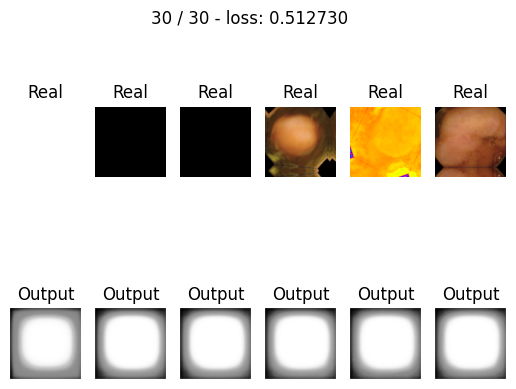

In [ ]:
max_epochs = 30
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.01)
losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce = train(model_transfer, optimizer, bce_loss, max_epochs, train_loader, val_loader)

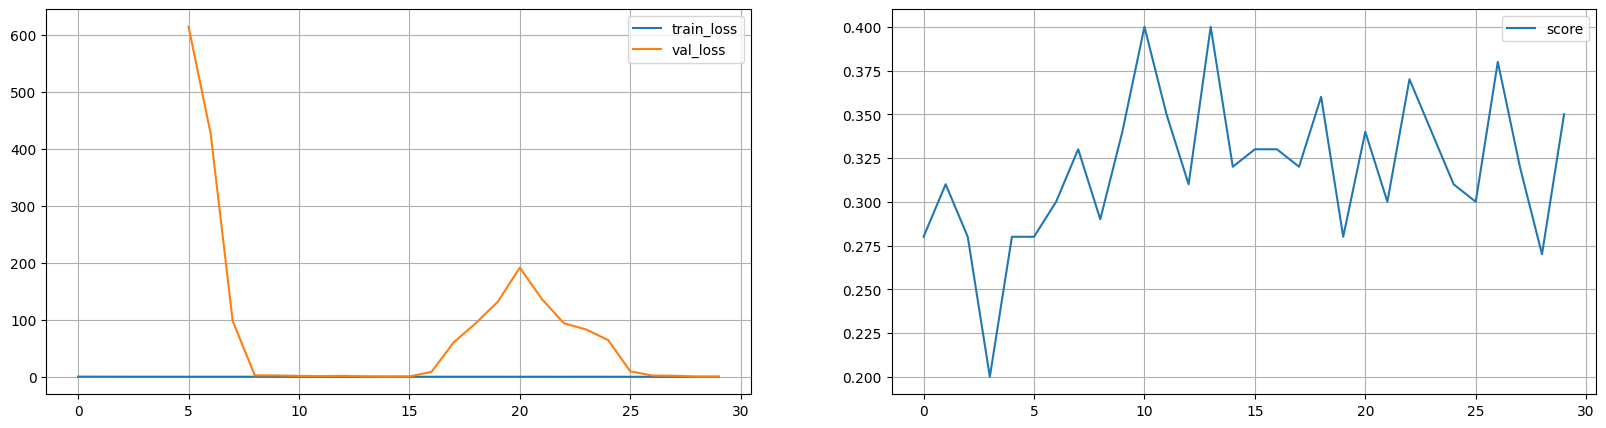

 функции потерь                                                         score на валидационной выборке : 0.4000000059604645


In [ ]:
max_score_val = plot(losses_train_unet_3_transfer, losses_test_unet_3_transfer_bce, scores_unet_3_transfer_bce)

Медицинские изображения очень чувствительны к различным искажениям, которые можут привести к неверному диагнозу.